# ML4FG Final Report Classical Code
### By: Austin Stiefelmaier 12/14/23

## Imports and Settings

In [2]:
# General imports
import os
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [5]:
# Fix random num generation for reproducibility 
torch.manual_seed(7)
np.random.seed(7)
# os.environ["OMP_NUM_THREADS"] = "1"
# If GPU available, set to run on it
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


## Load Data

In [6]:
# Data download
df_x = pd.read_csv('/home/as6734/ml4fg_class_project/TCGA-PANCAN-HiSeq-801x20531/data.csv')
df_y = pd.read_csv('/home/as6734/ml4fg_class_project/TCGA-PANCAN-HiSeq-801x20531/labels.csv')

In [7]:
# Clean data

# Drop first column that only notes sample number (which can be reconstructed from index if need be
df_x.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df_y.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
# Remove columns with all 0.0 values
df_x = df_x.loc[:, (df_x != 0).any(axis=0)]

In [8]:
# Pre-process data

# Normalize values by mean
df_x=(df_x-df_x.mean())/df_x.std()

# Encode classes
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(df_y.values)
y = enc.transform(df_y.values)

In [9]:
# Split data, final percentages are approximately 64% train, 16% validation, 20% test
x_train, x_test, y_train, y_test = train_test_split(df_x.values, y, test_size=0.2, train_size=0.8, random_state=7, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, train_size=0.8, random_state=7, stratify=y_train)
dataset_sizes = {'train': len(x_train), 'validation': len(x_valid), 'test': len(x_test)}
print(dataset_sizes)

{'train': 512, 'validation': 128, 'test': 161}


In [7]:
# Training data reductions to match percentages noted in future cells, 
# NOTE: all reduced slightly to %8
# x_train = x_train[0:int(dataset_sizes['train']*0.8-(dataset_sizes['train']*0.8)%8)]
# y_train = y_train[0:int(dataset_sizes['train']*0.8-(dataset_sizes['train']*0.8)%8)]

# x_train = x_train[0:int(dataset_sizes['train']*0.6-(dataset_sizes['train']*0.6)%8)]
# y_train = y_train[0:int(dataset_sizes['train']*0.6-(dataset_sizes['train']*0.6)%8)]

# x_train = x_train[0:int(dataset_sizes['train']*0.4-(dataset_sizes['train']*0.4)%8)]
# y_train = y_train[0:int(dataset_sizes['train']*0.4-(dataset_sizes['train']*0.4)%8)]

x_train = x_train[0:int(dataset_sizes['train']*0.2-(dataset_sizes['train']*0.2)%8)]
y_train = y_train[0:int(dataset_sizes['train']*0.2-(dataset_sizes['train']*0.2)%8)]

In [10]:
# Convert to DataLoaders
x_train_to_tensor = torch.from_numpy(x_train).to(torch.float32).to(device)
y_train_to_tensor = torch.from_numpy(y_train).to(torch.float32).to(device)
x_valid_to_tensor = torch.from_numpy(x_valid).to(torch.float32).to(device)
y_valid_to_tensor = torch.from_numpy(y_valid).to(torch.float32).to(device)
x_test_to_tensor = torch.from_numpy(x_test).to(torch.float32).to(device)
y_test_to_tensor = torch.from_numpy(y_test).to(torch.float32).to(device)

# Second step: Creating TensorDataset for Dataloader
train_set = TensorDataset(x_train_to_tensor, y_train_to_tensor)
valid_set = TensorDataset(x_valid_to_tensor, y_valid_to_tensor)
test_set = TensorDataset(x_test_to_tensor, y_test_to_tensor)

# Create DataLoader
dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True),
    'validation': torch.utils.data.DataLoader(valid_set, batch_size=8),
    'test': torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=8)
}

## Classical Architecture

In [11]:
# Classical Model Class
class ClassicalNet(nn.Module):
    # Initialize layers
    def __init__(self, num_feature):
        super().__init__()
        # Layers before quantum circuit
        self.layer_1 = nn.Linear(num_feature, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.layer_3 = nn.Linear(128, 64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.layer_4 = nn.Linear(64, 5)
        self.c1 = nn.Conv1d(8, 8, 2)
        self.layer_5 = nn.Linear(4, 5)
        # Misc
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    # Forward pass procedure
    def forward(self, x):
        # First layer
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        # Second layer
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Third layer
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Quantum stand in layers 
        x = self.layer_4(x)
        x = self.c1(x)
        x = torch.flatten(x, 1)
        x = self.layer_5(x)
        return x

In [12]:
# Instantiate model
model = ClassicalNet(num_feature=len(df_x.columns))
# Make sure set to use GPU
model = model.to(device)
# Show model architecture summary
print(model)

ClassicalNet(
  (layer_1): Linear(in_features=20264, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_4): Linear(in_features=64, out_features=5, bias=True)
  (c1): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (layer_5): Linear(in_features=4, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


## Train Classical

In [11]:
step = 0.0004  # Initial learning rate
batch_size = 8
num_epochs = 50
gamma_lr_scheduler = 0.1  # Learning rate decay param

In [12]:
# Set up loss, optimizer, and learning rate decay manager
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, step_size=10, gamma=gamma_lr_scheduler
)

In [13]:
# Function to train model(s)
def train(model, loss_func, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000.0
    best_loss_train = 100000.0
    print('Training started:')
    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'validation']:
            if phase == 'train':
                # Set model to train mode
                model.train()
            else:
                # Set model to eval mode
                model.eval()
            current_loss = 0.0
            n_batches = dataset_sizes[phase] // batch_size
            iter = 0
            for X, Y in dataloaders[phase]:
                batch_len = len(X)
                X = X.to(device)
                optimizer.zero_grad()  # Reset gradients
                # If in train mode, get loss, step optimizer
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(X)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_func(outputs, Y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # Print iteration results
                current_loss += loss.item() * batch_len
                print('Phase: {} Epoch: {}/{} Iter: {}/{}'.format(phase, epoch+1, num_epochs, iter+1, n_batches+1),
                    end="\r",
                    flush=True)
                iter += 1

            # Get epoch stats and print
            epoch_loss = current_loss / dataset_sizes[phase]
            print('Phase: {} Epoch: {}/{} Loss: {:.4f}        '.format(
                    'train' if phase == 'train' else 'validation  ',
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                )
            )
            # Update best vars and make copy of best weights
            # if phase == "validation":
            #     best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
            # Decay learning rate
            if phase == "train":
                scheduler.step()
    # Print final results
    model.load_state_dict(best_model_wts)
    print('Best test loss: {:.4f}'.format(best_loss))
    return model

In [14]:
model = train(model, loss_func, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
torch.save(model.state_dict(), './weights/updated20_classical_50epochs.pt')

Training started:


  0%|          | 0/50 [00:00<?, ?it/s]

Phase: train Epoch: 1/50 Loss: 0.3262        
Phase: validation   Epoch: 1/50 Loss: 1.6868        
Phase: train Epoch: 2/50 Loss: 0.3160        
Phase: validation   Epoch: 2/50 Loss: 1.6780        
Phase: train Epoch: 3/50 Loss: 0.3187        
Phase: validation   Epoch: 3/50 Loss: 1.6697        
Phase: train Epoch: 4/50 Loss: 0.3122        
Phase: validation   Epoch: 4/50 Loss: 1.6682        
Phase: train Epoch: 5/50 Loss: 0.3186        
Phase: validation   Epoch: 5/50 Loss: 1.6644        
Phase: train Epoch: 6/50 Loss: 0.3236        
Phase: validation   Epoch: 6/50 Loss: 1.6637        
Phase: train Epoch: 7/50 Loss: 0.3217        
Phase: validation   Epoch: 7/50 Loss: 1.6620        
Phase: train Epoch: 8/50 Loss: 0.3120        
Phase: validation   Epoch: 8/50 Loss: 1.6595        
Phase: train Epoch: 9/50 Loss: 0.3073        
Phase: validation   Epoch: 9/50 Loss: 1.6556        
Phase: train Epoch: 10/50 Loss: 0.3084        
Phase: validation   Epoch: 10/50 Loss: 1.6532        
Phase: t

In [16]:
preds, targets = test(model, 'cpu', dataloaders['test'])
print(accuracy_score(y_true=targets, y_pred=preds))
print(classification_report(y_true=targets, y_pred=preds))

  0%|          | 0/21 [00:00<?, ?it/s]

0.2
              precision    recall  f1-score   support

        BRCA       0.71      0.08      0.15        59
        COAD       0.00      0.00      0.00        16
        KIRC       0.00      0.00      0.00        30
        LUAD       0.00      0.00      0.00        28
        PRAD       0.18      1.00      0.30        27

    accuracy                           0.20       160
   macro avg       0.18      0.22      0.09       160
weighted avg       0.29      0.20      0.11       160



/opt/conda/envs/ml4fg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ml4fg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/ml4fg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test Classical

In [13]:
# Helper function to test model
def test(model, device, test_loader):
    preds = []
    targets = []
    with torch.no_grad():
        model.eval()
        for data, target in tqdm(test_loader):
            # Send the data and target to device
            data, target = data.to(device), target.to(device)
            if data.size()[0] < 8:
                break
            output = model(data)
            preds += enc.inverse_transform(output).flatten().tolist()
            targets += enc.inverse_transform(target).flatten().tolist()
    return preds, targets

# Helper function to load in weights and send to test function
def load_and_test(percentage, model_type):
    best_weights = torch.load(f'./weights/updated{percentage}_{model_type}_50epochs.pt')
    model.load_state_dict(best_weights)
    model.eval()
    preds, targets = test(model, 'cpu', dataloaders['test'])
    return accuracy_score(y_true=targets, y_pred=preds)

In [14]:
percentages = [20, 40, 60, 80]
acc_class = []
for percentage in percentages:
    acc_class.append(load_and_test(percentage, 'classical'))

# Add in full training results from interim report notebook
acc_class.append(0.76)
percentages.append(100)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
# NOTE: See final_report_hqnn notebook to see where these numbers came from
# 0.9627329192546584
acc_hybrid = [
 0.9565217391304348,
 0.9565217391304348,
 0.9565217391304348,
 0.968944099378882,
0.99]

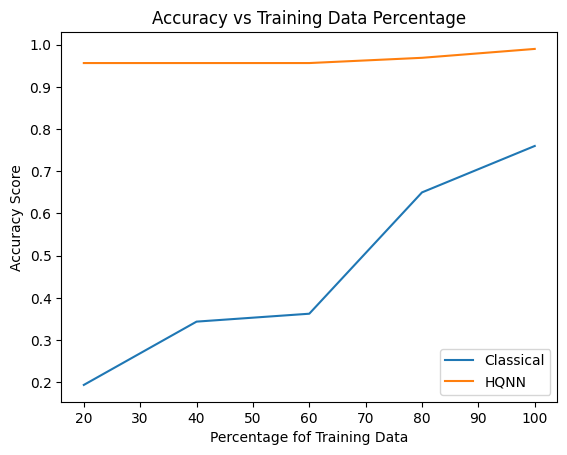

In [16]:
plt.plot(percentages, acc_class, label='Classical')
plt.plot(percentages, acc_hybrid, label='HQNN')
plt.title('Accuracy vs Training Data Percentage')
plt.xlabel('Percentage fof Training Data')
plt.ylabel('Accuracy Score')
plt.legend()
plt.savefig('acc_training_percentage.png')